# Comparació amb els resultats d'una extracció atmosfèrica tradicional

### En aquest notebook es comparen els resultats obtinguts amb XGBoost, amb els obtinguts en una extracció atmosfèrica tradicional amb l'optimitzador Nested Sampling.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
param_names = np.load('/kaggle/input/tfm2a-preparar-dades/Y_FM_names.npy')

## Resultats obtinguts amb Nested Sampling Optimizer

L'ABC Database inclou els resultats d'una extracció atmosfèrica Bayesiana estàndard per una fracció de les dades.

In [3]:
# Resultats del Nested Sampling (només calculat per 26109 de les mostres)
quartiles_data = pd.read_csv("/kaggle/input/abc-database/Level2Data/Ground Truth Package/QuartilesTable.csv")
planet_idx = list(range(0, quartiles_data.shape[0]))

# Dividim les mostres com en els conjunts train i test utilitzats per fer els models (mateixa seed) 
quartiles_train, quartiles_test, planet_idx_train, planet_idx_test = train_test_split(quartiles_data, planet_idx, test_size = 0.25, random_state = 42)
print('Mostres en el conjunt train:', quartiles_train.shape)
print('Mostres en el conjunt test:', quartiles_test.shape)


# El conjunt test és el que compararem amb els resultats dels nostres models.
# Ens quedem només amb les medianes (q2)
q2_cols = [col for col in quartiles_test.columns if 'q2' in col]
quartiles_test = quartiles_test.loc[:, ['planet_ID'] + q2_cols ]
# Eliminem les files que no tenen resultat del Nested Sampling
quartiles_test = quartiles_test.dropna(subset=q2_cols)

# Mostres que ens queden amb resultats del Nested Sampling
print('Tenim ', quartiles_test.shape[0], " mostres del conjunt test amb resultats del Nested Sampling")

# Indexos d'aquests planetes, per alinear els següents conjunts de dades
test_nested_sampling_idx = quartiles_test['planet_ID'].values

# Igualem els noms de les columnes
quartiles_test.columns = np.append(['planet_ID'], param_names)


# Mostra del conjunt de dades resultant
quartiles_test.head(5)



Mostres en el conjunt train: (68544, 19)
Mostres en el conjunt test: (22848, 19)
Tenim  5454  mostres del conjunt test amb resultats del Nested Sampling


,planet_ID,planet_temp,log_H2O,log_CO2,log_CH4,log_CO,log_NH3
11702,11702,920.424752,-5.917573,-7.926230,-6.431402,-6.874099,-9.632523
1122,1122,621.492513,-3.584345,-7.583799,-9.497199,-3.689470,-5.810707
21351,21351,1098.925544,-7.314160,-6.733695,-9.377148,-3.087140,-9.279871
16055,16055,821.250605,-5.888954,-6.427536,-9.548582,-3.183794,-6.502562
16701,16701,2577.591082,-9.432330,-4.184511,-9.383584,-4.366239,-9.230968


## Paràmetres atmosfèrics utilitzats per generar els espectres sintètics (ground truth)

Extraiem les files per les quals també tenim resultats del Nested Sampling per poder comparar.

In [4]:
# Dades "ground truth": valors utilitzats en els forward models (FM) per sintetitzar els espectres atmosfèrics.
FM_params = pd.read_csv("/kaggle/input/abc-database/Level2Data/Ground Truth Package/FM_Parameter_Table.csv")

# Ens quedem només aquells planetes pels quals tenim resultats del Nested Sampling
FM_params = FM_params.filter(items = test_nested_sampling_idx, axis=0)

# Ens fixem que el data frame ens queda ben alineat amb quartiles_test
FM_params.head(5)

,planet_ID,planet_temp,log_H2O,log_CO2,log_CH4,log_CO,log_NH3
11702,11702,919.974770,-5.914162,-7.936286,-6.419505,-5.932870,-8.406560
1122,1122,621.029250,-3.582140,-7.494215,-8.196888,-3.680911,-5.802422
21351,21351,1094.955219,-7.120409,-6.715728,-7.896155,-3.064558,-7.867935
16055,16055,819.182199,-5.878053,-6.407439,-8.130553,-3.166822,-6.474367
16701,16701,2575.720334,-7.572434,-4.192789,-7.842698,-4.064807,-8.705457


## Resultats del XGBoost

In [5]:

xgboost_results = np.load('/kaggle/input/tfm3-xgboost-resultats/XGBoost_y_pred_results.npy') 

# Creem el dataframe amb els resultats del XBGoost
xgboost = pd.DataFrame(xgboost_results, columns=param_names)
# Reconstruïm els índexos del conjunt test
xgboost['index'] = planet_idx_test
xgboost = xgboost.set_index('index')

# Filtrem només aquelles files per les quals tenim resultats del Nested Samling
xgboost = xgboost.filter(items = test_nested_sampling_idx, axis=0)

# Ens fixem que el data frame ens queda ben alineat amb quartiles_test i FM_params
xgboost.head(5)

,planet_temp,log_H2O,log_CO2,log_CH4,log_CO,log_NH3
index,,,,,,
11702,888.829834,-6.116407,-7.889087,-6.488949,-5.968638,-8.143084
1122,667.861023,-3.609563,-7.558945,-8.348095,-3.706933,-5.824518
21351,983.939453,-7.345147,-6.775882,-8.005887,-3.139772,-7.937578
16055,815.419678,-5.684430,-6.329272,-8.317418,-3.091281,-6.598568
16701,2522.006348,-7.712863,-4.140563,-7.954430,-4.084507,-7.574121


## Comparació de resultats entre mètodes

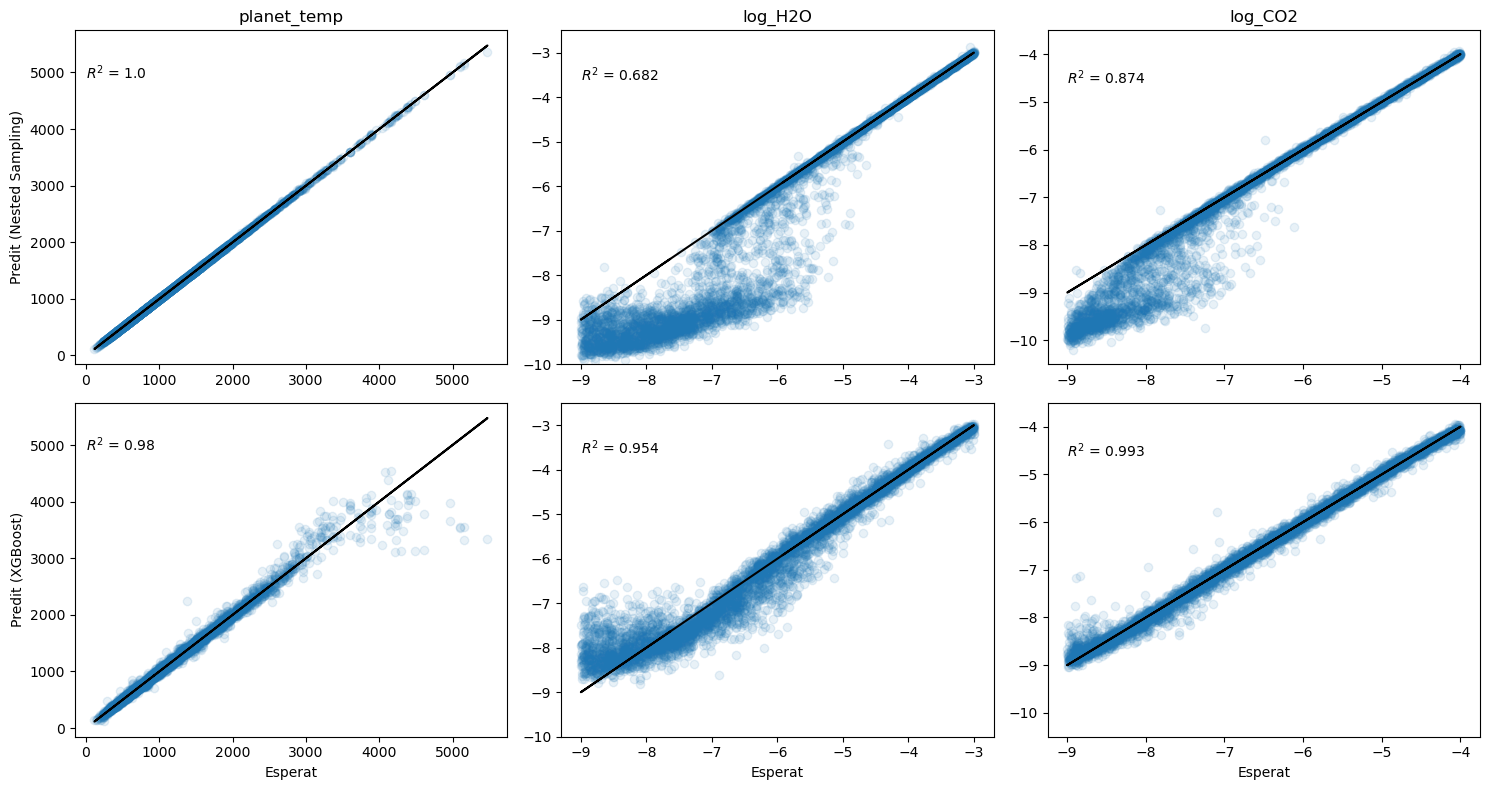

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
alpha_level = 0.1

nParam = 0 # TEMPERATURA
x = FM_params[param_names[nParam]]; y = quartiles_test[param_names[nParam]]
axes[0,0].scatter(x, y, alpha = alpha_level) #, c=pca_labels_test
axes[0,0].set(title = param_names[nParam], xlabel = '', ylabel = 'Predit (Nested Sampling)' )
axes[0,0].plot(x,x,'k-')
R2 = r2_score(x, y)
axes[0,0].text(0, 5000, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = FM_params[param_names[nParam]]; y = xgboost[param_names[nParam]]
axes[1,0].scatter(x, y, alpha = 0.1) 
axes[1,0].set(title = '', xlabel = 'Esperat', ylabel = 'Predit (XGBoost)')
axes[1,0].plot(x, x,'k-')
R2 = r2_score(x, y)
axes[1,0].text(0, 5000, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

nParam = 1 # H20
x = FM_params[param_names[nParam]]; y = quartiles_test[param_names[nParam]]
axes[0,1].scatter(x, y, alpha = alpha_level) 
axes[0,1].set(title = param_names[nParam],xlabel = '', ylabel = '', ylim=[-10,-2.5])
axes[0,1].plot(x, x,'k-')
R2 = r2_score(x, y)
axes[0,1].text(-9, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = FM_params[param_names[nParam]]; y = xgboost[param_names[nParam]]
axes[1,1].scatter(x, y, alpha = 0.1) 
axes[1,1].set(title = '', xlabel = 'Esperat', ylabel = '', ylim=[-10,-2.5])
axes[1,1].plot(x, x,'k-')
R2 = r2_score(x, y)
axes[1,1].text(-9, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')


nParam = 2 # CO2
x = FM_params[param_names[nParam]]; y = quartiles_test[param_names[nParam]]
axes[0,2].scatter(x, y, alpha = alpha_level) 
axes[0,2].set(title = param_names[nParam], xlabel = '', ylabel = '', ylim=[-10.5,-3.5] )
axes[0,2].plot(x, x,'k-')
R2 = r2_score(x, y)
axes[0,2].text(-9, -4.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = FM_params[param_names[nParam]]; y = xgboost[param_names[nParam]]
axes[1,2].scatter(x, y, alpha = 0.1) 
axes[1,2].set(title = '', xlabel = 'Esperat', ylabel = '', ylim=[-10.5,-3.5])
axes[1,2].plot(x, x,'k-')
R2 = r2_score(x, y)
axes[1,2].text(-9, -4.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

plt.tight_layout()
plt.show()

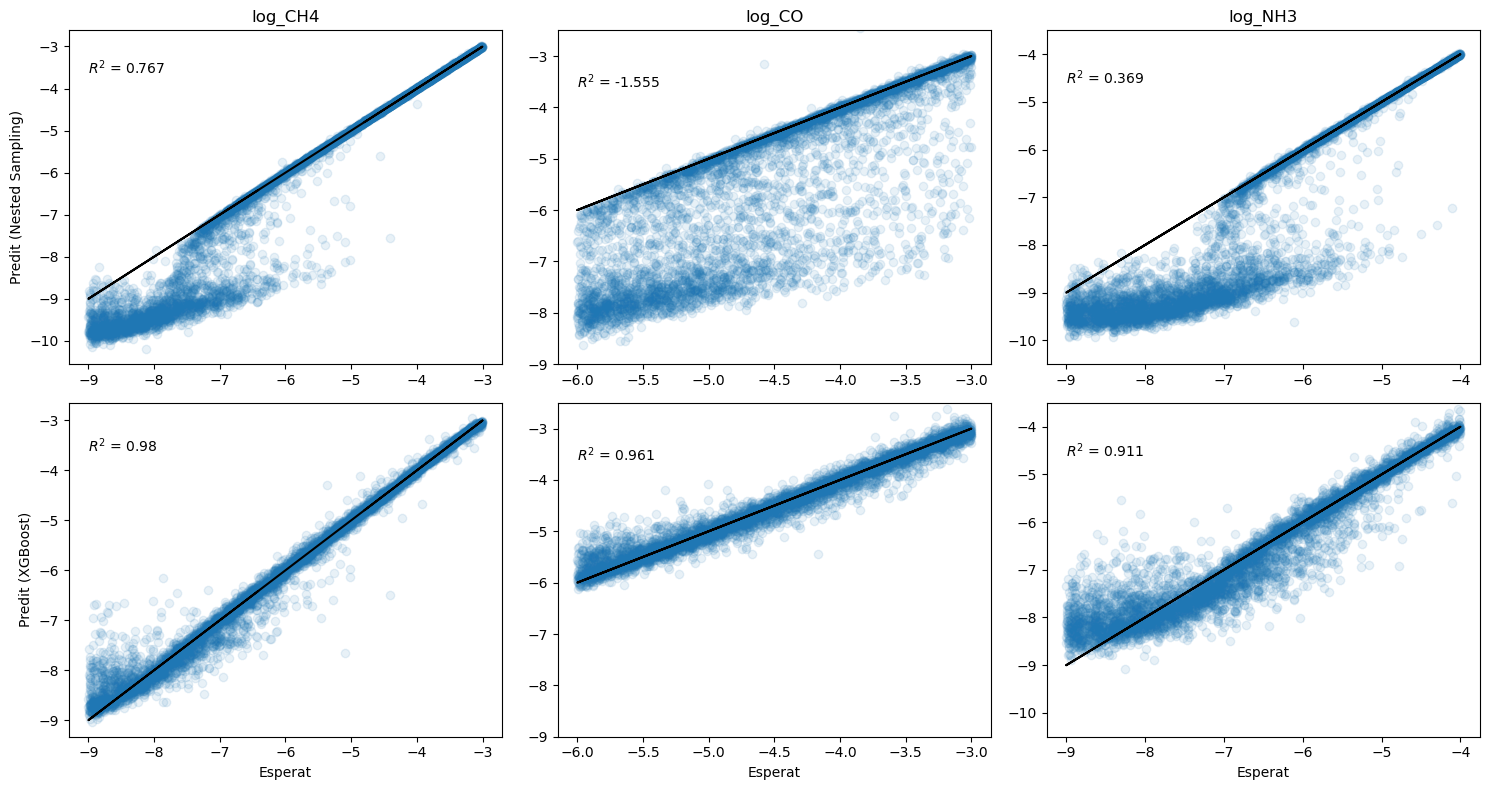

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
alpha_level = 0.1

nParam = 3 # CH4
x = FM_params[param_names[nParam]]; y = quartiles_test[param_names[nParam]]
axes[0,0].scatter(x, y, alpha = alpha_level) #, c=pca_labels_test
axes[0,0].set(title = param_names[nParam], xlabel = '', ylabel = 'Predit (Nested Sampling)' )
axes[0,0].plot(x,x,'k-')
R2 = r2_score(x, y)
axes[0,0].text(-9, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = FM_params[param_names[nParam]]; y = xgboost[param_names[nParam]]
axes[1,0].scatter(x, y, alpha = alpha_level) #, c=pca_labels_test
axes[1,0].set(title = '', xlabel = 'Esperat', ylabel = 'Predit (XGBoost)')
axes[1,0].plot(x,x,'k-')
R2 = r2_score(x, y)
axes[1,0].text(-9, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

nParam = 4 # CO
x = FM_params[param_names[nParam]]; y = quartiles_test[param_names[nParam]]
axes[0,1].scatter(x, y, alpha = alpha_level) #, c=pca_labels_test
axes[0,1].set(title = param_names[nParam],xlabel = '', ylabel = '', ylim=[-9,-2.5])
axes[0,1].plot(x, x,'k-')
R2 = r2_score(x, y)
axes[0,1].text(-6, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = FM_params[param_names[nParam]]; y = xgboost[param_names[nParam]]
axes[1,1].scatter(x, y, alpha = 0.1) #, c=pca_labels_test
axes[1,1].set(title = '', xlabel = 'Esperat', ylabel = '', ylim=[-9,-2.5])
axes[1,1].plot(x, x,'k-')
R2 = r2_score(x, y)
axes[1,1].text(-6, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

nParam = 5 # CO2
x = FM_params[param_names[nParam]]; y = quartiles_test[param_names[nParam]]
axes[0,2].scatter(x, y, alpha = alpha_level) #, c=pca_labels_test
axes[0,2].set(title = param_names[nParam], xlabel = '', ylabel = '', ylim=[-10.5,-3.5] )
axes[0,2].plot(x, x,'k-')
R2 = r2_score(x, y)
axes[0,2].text(-9, -4.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = FM_params[param_names[nParam]]; y = xgboost[param_names[nParam]]
axes[1,2].scatter(x, y, alpha = 0.1) #, c=pca_labels_test
axes[1,2].set(title = '', xlabel = 'Esperat', ylabel = '', ylim=[-10.5,-3.5])
axes[1,2].plot(x, x,'k-')
R2 = r2_score(x, y)
axes[1,2].text(-9, -4.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')


plt.tight_layout()
plt.show()